# Manual for A/B Test Calculation using Interrupted Time Series (ITS) with Bayesian Approach

As a data analyst working with mobile application / web products, A/B testing is a common task to evaluate the impact of features on app performance. For example, testing whether moving a button for ordering from the bottom to the top of the screen increases transaction rates. Conducting a successful A/B test requires careful planning, with sample size determination being a critical step.

However, limited resources can pose challenges. What if **you can't direct traffic to the A or B version** of the app? What if **you can't achieve the required sample size** due to a small user base, which is often the case for startups? In such situations, conducting traditional A/B tests becomes difficult.

This notebook introduces a statistical methodology called **Interrupted Time Series (ITS) and its Bayesian counterpart**. ITS allows for the evaluation of interventions or changes in a time series data set, making it a valuable tool when traditional A/B testing is impractical.

# 1. The Theory of Interrupted Time Series

## 1.1. The Basic

The Interrupted Time Series (ITS) approach is one of the **quasi experiment methods a method used to establish cause-and-effect relationships without relying on randomization**. Unlike randomized experiments, which randomly assign participants to treatment and control groups, quasi-experiments like ITS use criteria other than randomization to allocate participants. This approach is particularly useful in situations where randomization is not feasible or ethical.

ITS itself is a statistical method used to **evaluate the impact of an intervention or treatment by analyzing a time series of data before and after the intervention**. It is commonly used in fields such as healthcare, economics, and social sciences to assess the effectiveness of policy changes, new treatments, or other interventions.

Key features of the ITS approach include:

1. **Longitudinal Data:** ITS uses longitudinal data collected at multiple time points before and after the intervention. This allows researchers to observe trends in the outcome variable over time.

2. **Intervention Point:** The intervention point is the time at which the intervention occurred. It serves as the reference point for comparing the pre-intervention and post-intervention periods.

3. **Control for Time Trends:** ITS models typically include time as a variable to control for underlying trends in the outcome variable that are unrelated to the intervention. This helps to isolate the effect of the intervention from other factors.

4. **Control for Seasonality:** ITS can also control for seasonal patterns in the data, such as weekly or monthly fluctuations, by including appropriate seasonal terms in the model.

5. **Regression Analysis:** ITS analysis is often conducted using regression analysis, where the outcome variable is regressed on time, the intervention indicator (a binary variable indicating pre- or post-intervention), and potentially other covariates.

6. **Assumption of Linearity:** ITS assumes a linear relationship between time and the outcome variable, as well as a linear effect of the intervention on the outcome.

7. **Robustness Checks:** Researchers often perform robustness checks, such as sensitivity analyses or placebo tests, to assess the validity of the results and the robustness of the estimated intervention effect.

The Interrupted Time Series (ITS) approach compares data before and after an intervention to detect its effect, eliminating the need for separate control and treatment groups as both of them are ran simultaneously.

<img src="images/diagram_its.png" width=1000>

## 1. 2. Equation

The ITS regression equation allows us to determine coefficients to understand the impact of an intervention over time. Put simply, it can be expressed as:

$Y_t = \beta_0 + \beta_1 Time + \beta_2 Intervention + \beta_3 Time\_after\_intervention$ 

In a more mathematical form:

$Y_t = \beta_0 + \beta_1 t + \beta_2 x_t + \beta_3 [t-T]x_t$ 

where...

- $Y_t$ is the outcome variable at time $t$
- $t$ is a continuous variable representing time
- $x_t$ is a binary variable indicating whether the observation occurred before or after the intervention
- $[t-T]$ continuous variable representing the time elapsed since the intervention (0 for pre-intervention observations)

We can also include exogenous variables or using SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Factors) components to account for external factors, seasonality, and autocorrelation:

$Y_t = \beta_0 + \beta_1 t + \beta_2 x_t + \beta_3 [t-T]x_t + \gamma X_t + \phi Z_t$ 

where 

- $X_t$ represents the exogenous variables (e.g., external factors that could impact the outcome)
- $\gamma$ are the coefficients for the exogenous variables.
- $\phi Z_t$ represents the SARIMAX component, $Z_t$ where is the SARIMAX model including any seasonal and lagged components.

Now, let's take it into action!

# 2. Dataset

For this example, we'll utilize data from an A/B testing scenario in a website, sourced from <a href="https://www.kaggle.com/datasets/saraabdelaal/abtestdata/data">saraabdelaal's dataset on Kaggle</a>. While the documentation is not comprehensive, the dataset contains a sufficient number of data points and, crucially, includes a timestamp. This timestamp column will be valuable for simulating the calculation for ITS.

## 2.1. Extraction, Cleaning, and Transformation

In [1]:
!kaggle datasets download -d saraabdelaal/abtestdata

abtestdata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile

# extract the zipfile for python to be able to read the dataset
# save into "dataset" folder
with zipfile.ZipFile('abtestdata.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [3]:
import pandas as pd

# read and take a sneak peek of the data itself
df = pd.read_csv('dataset/ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# profile of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# check the count of unique
# nunique of user id shold be in the same length with the len of df
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [6]:
# check the user id, and
# we found that there are some users indeed went through the control and treatment
df[df['user_id'].duplicated(keep=False)].sort_values('user_id').head(5)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0


In [7]:
# thus we only keep the first duplicate of the user id
# and drop the spill overs
df = df[~df['user_id'].duplicated(keep='last')]

In [8]:
# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# and remove the hour
df['timestamp_date'] = df['timestamp'].dt.strftime('%Y-%m-%d')

In [9]:
# create an hour group + date column
# to be able to plot the time series in a more granular way + populate  data points

# mapping the hour group

def map_hour_to_group(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'midnight'

df['hour_group'] = df['timestamp'].dt.hour.apply(map_hour_to_group)

# now sorting the hour group so the morning comes before afternoon, etc.

hour_group_order = ['morning', 'afternoon', 'evening', 'midnight']

df['hour_group'] = pd.Categorical(df['hour_group'], categories=hour_group_order, ordered=True)
df.sort_values(by=['timestamp_date', 'hour_group'], inplace=True)

In [10]:
# rearrage all the columns, and take only the important ones
df = df[['user_id', 'timestamp', 'timestamp_date', 'hour_group', 'landing_page', 'converted']]
df.head(5)

,user_id,timestamp,timestamp_date,hour_group,landing_page,converted
211,817695,2017-01-02 14:27:16.119037,2017-01-02,afternoon,old_page,0
288,908149,2017-01-02 15:36:49.134321,2017-01-02,afternoon,old_page,0
472,831672,2017-01-02 17:23:32.189476,2017-01-02,afternoon,new_page,1
503,730577,2017-01-02 17:32:29.210020,2017-01-02,afternoon,old_page,0
577,673153,2017-01-02 17:22:42.391404,2017-01-02,afternoon,old_page,1


## 2.2. Exploratory Data Analysis (EDA)

/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_41349/3657175961.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df.groupby('landing_page').agg('mean')['converted']


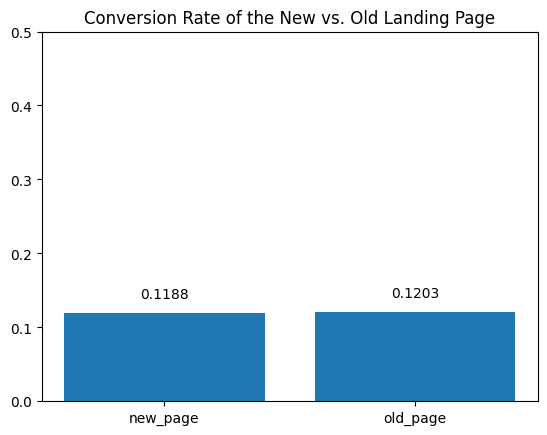

In [11]:
import matplotlib.pyplot as plt

# plot the conversion rate betwen old_page and new_page

df_temp = df.groupby('landing_page').agg('mean')['converted']
plt.bar(x=df_temp.index, height=df_temp)
plt.ylim(0,0.5)

for i, value in enumerate(df_temp):
    plt.text(i, value + 0.02, str(round(value, 4)), ha='center')

plt.title('Conversion Rate of the New vs. Old Landing Page')
plt.show()

/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_41349/3533341969.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df.groupby(['timestamp_date','landing_page']).agg('mean')[['converted']].reset_index()


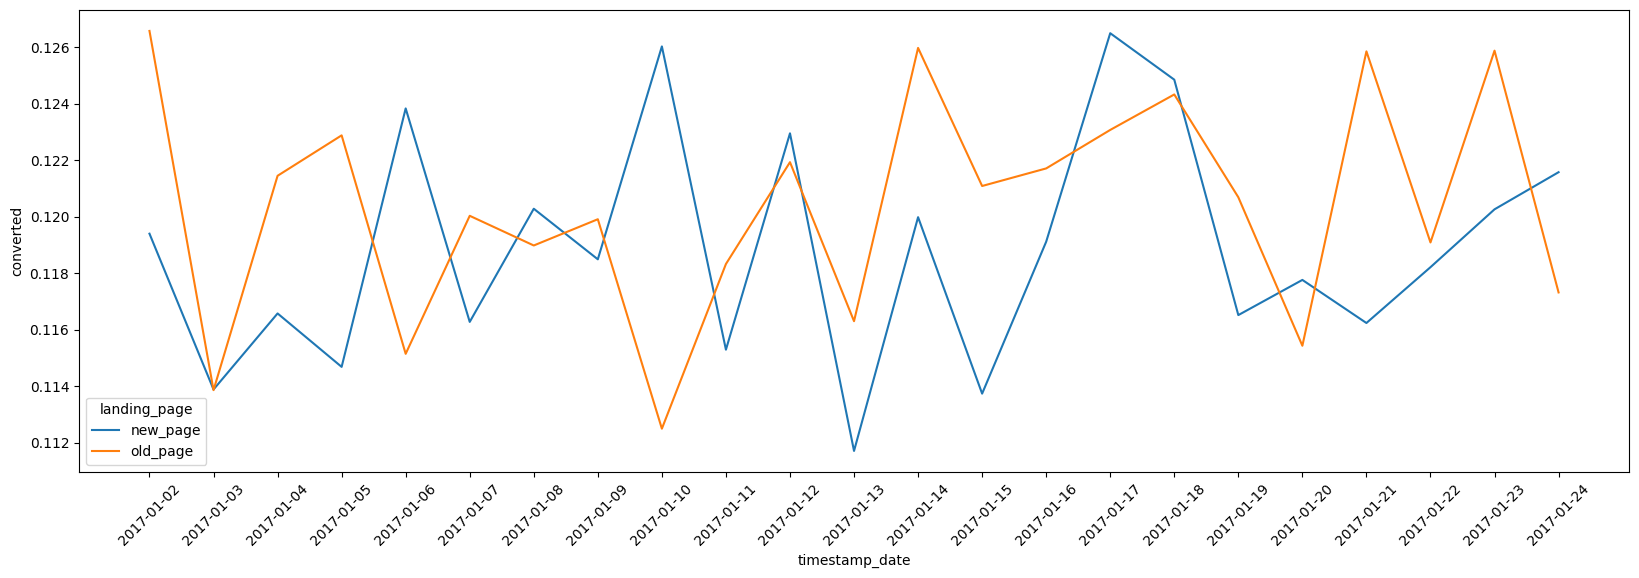

In [12]:
import seaborn as sns

# plot the conversion rate in a time series daily

plt.figure(figsize=(20,6))

df_temp = df.groupby(['timestamp_date','landing_page']).agg('mean')[['converted']].reset_index()
sns.lineplot(data=df_temp, x='timestamp_date', y='converted', hue='landing_page')

plt.xticks(rotation=45)
plt.show()

/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_41349/2320684124.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df.groupby(['timestamp_date', 'hour_group', 'landing_page']).agg('mean')[['converted']].reset_index()


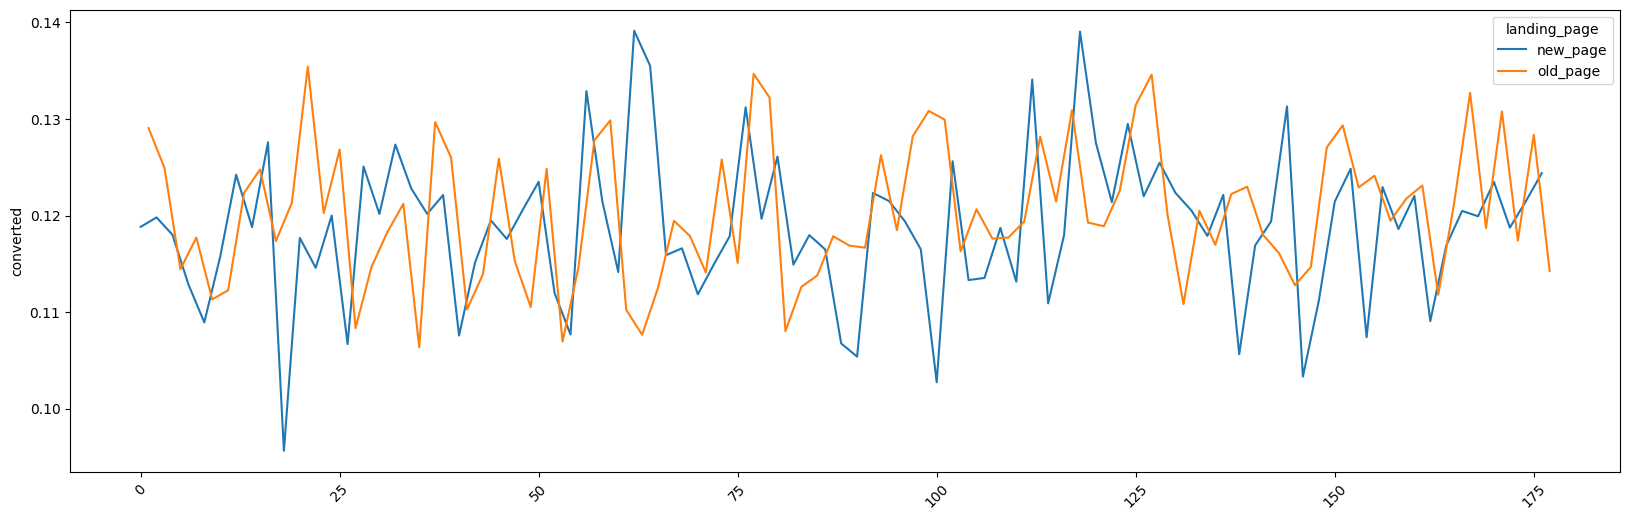

In [13]:
# to populate data, let's try group and plot it by hour groups of morning, afternoon, evening, and midnight

df_temp = df.groupby(['timestamp_date', 'hour_group', 'landing_page']).agg('mean')[['converted']].reset_index()
df_temp = df_temp[~df_temp['converted'].isna()].reset_index(drop=True)

plt.figure(figsize=(20,6))

sns.lineplot(data=df_temp, x=df_temp.index, y='converted', hue='landing_page')

plt.xticks(rotation=45)
plt.show()

# 3. Data Analysis

## 3.1. Difference test using Chi-Square for Baseline

In [14]:
# define the function for odds ratio
# for the power analysis for chi-square
def odds_ratio(df_cross, control_var, treat_var):

    control = df_cross.loc[1, control_var] / df_cross.loc[0, control_var]
    treatment = df_cross.loc[1, treat_var] / df_cross.loc[0, treat_var]

    odds_ratio = treatment / control

    return round(odds_ratio, 3)

In [15]:
import scipy.stats as stats

df_test = pd.crosstab(df['landing_page'], df['converted'])
df_cross_normal = pd.crosstab(df['landing_page'], df['converted'], normalize='index') - pd.crosstab(df['landing_page'], df['converted'], normalize='index').loc['old_page', 1]
prop_diff = df_cross_normal.loc['new_page', 1] - df_cross_normal.loc['old_page', 1]
odds_ratio_val = odds_ratio(df_test.T, 'old_page', 'new_page')
chi_test, p_val, _, _ = stats.chi2_contingency(df_test)

print(f'proportion difference between two groups: {round(prop_diff, 3)}')
print(f'odds ratio (power analysis) is: {round(odds_ratio_val, 3)}')
print(f'chi-test statistic is at: {round(chi_test, 3)}')
print(f'p-value is at: {round(p_val, 3)}')

proportion difference between two groups: -0.001
odds ratio (power analysis) is: 0.986
chi-test statistic is at: 1.411
p-value is at: 0.235


## 3.2. Simulation with ITS

### 3.2.1 Prepare and transform the dataset first

In [16]:
import math

# determine the cutoff date for the simulation
cutoff = math.ceil((df['timestamp'].max() - df['timestamp'].min()).days / 2)
cutoff_date = (df['timestamp'].min() + pd.Timedelta(days=cutoff)).date()
cutoff_date = cutoff_date.strftime('%Y-%m-%d')

# calculate the mean for each group
df_temp = df.groupby(['timestamp_date','landing_page']).agg('mean')[['converted']].reset_index()

# create dataframe, both for control and treatment
df_control = df_temp[(df_temp['landing_page'] == 'old_page') & (df_temp['timestamp_date'] < cutoff_date)]
df_treat = df_temp[(df_temp['landing_page'] == 'new_page') & (df_temp['timestamp_date'] >= cutoff_date)]
df_test = df_control.append(df_treat).reset_index(drop=True)

# create column for intervention and intervention week; week when the intervention starts
intervention_start_week = 11

df_test['week'] = range(1, len(df_test) + 1)
df_test['intervention'] = [1 if x == 'new_page' else 0 for x in df_test['landing_page']]
df_test['intervention_week'] = [i - intervention_start_week + 1 if i >= intervention_start_week else 0 for i in range(1, len(df_test) + 1)]

/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_41349/2593079172.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df.groupby(['timestamp_date','landing_page']).agg('mean')[['converted']].reset_index()
/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_41349/2593079172.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_control.append(df_treat).reset_index(drop=True)


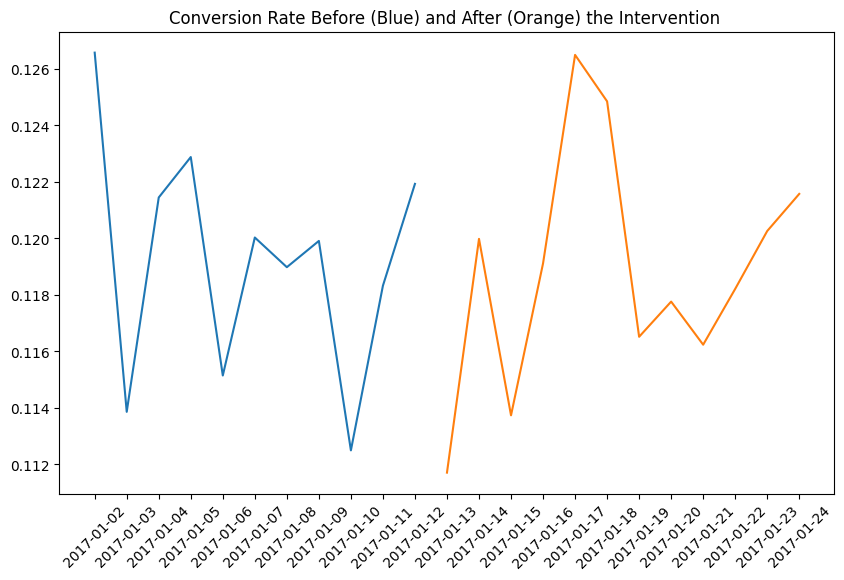

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(df_control['timestamp_date'], df_control['converted'])
plt.plot(df_treat['timestamp_date'], df_treat['converted'])

plt.xticks(rotation=45)
plt.title('Conversion Rate Before (Blue) and After (Orange) the Intervention ')

plt.show()

### 3.2.2 Statistical Analysis

##### 3.2.2.1. Determine the SARIMAX Parameter

To be able to correctly put the varaibles into our ITS model, we have to know the parameteres of the SARIMAX variables.

In [18]:
import pmdarima as pm

# use the pmdarima library to look for the best parameters
# set "trace" parameter as true to be able to track how the model attempts to look for the variables

sarimax_model = pm.auto_arima(df_test['converted'], 
                              test='adf',
                              seasonal=True,
                              trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-148.666, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-131.788, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-138.225, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-146.702, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-144.299, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-148.223, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-147.457, Time=0.08 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-148.204, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-148.340, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-147.595, Time=0.03 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-146.822, Time=0.07 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-145.949, Time=0.05 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 0.668 seconds


The notation "ARIMA(2,2,2)(0,0,0)[0]" describes the best-fitting ARIMA model obtained by the `auto_arima` function.

- ARIMA(p,d,q): This indicates the non-seasonal part of the ARIMA model. 
  - p: The number of autoregressive (AR) terms.
  - d: The number of differences needed for stationarity.
  - q: The number of moving average (MA) terms.

In this case, the non-seasonal part of the model is ARIMA(2,2,2), which means it includes 2 AR terms, 2 differences for stationarity, and 2 MA terms.

- (0,0,0)[0]: This indicates the seasonal part of the ARIMA model. 
  - The numbers in the parentheses represent the seasonal AR, differencing, and MA terms, respectively. Since they are all 0, it means there are no seasonal components in the model.
  - The number in the square brackets represents the seasonal period, which is 0, indicating no seasonality.

Putting it all together, **"ARIMA(2,2,2)(0,0,0)[0]"** represents a **non-seasonal ARIMA model with 2 AR terms, 2 differences for stationarity, and 2 MA terms, and no seasonal components**.

#### 3.2.2.2. Fit the ITS model

After we know what's the best parameters for the SARIMAX model, we can now fit the model using statsmodels library.

In [19]:
import statsmodels.api as sm

# fit the model using statsmodels.tsa.sarimax
# put the y-variable (conversion rate) into the endog parameter
# we can leverage this library by putting the its variables in the exog parameter
# finally, pass the order and seasonal order like we found previously

exog_with_intercept = sm.add_constant(df_test[['week', 'intervention', 'intervention_week']])

its_model = sm.tsa.SARIMAX(endog=df_test['converted'],
                           exog=exog_with_intercept,
                           order=(2,2,2),
                           seasonal_order=(0,0,0,0)
                           ).fit()

its_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.26598D+00    |proj g|=  4.68546D+01

At iterate    5    f= -3.32253D+00    |proj g|=  3.79286D+00

At iterate   10    f= -3.32871D+00    |proj g|=  1.06930D+00

At iterate   15    f= -3.44733D+00    |proj g|=  4.72643D+00

At iterate   20    f= -3.45753D+00    |proj g|=  1.61273D+00

At iterate   25    f= -3.47826D+00    |proj g|=  5.66902D+00

At iterate   30    f= -3.49063D+00    |proj g|=  1.44557D+00

At iterate   35    f= -3.49113D+00    |proj g|=  5.24159D-01

At iterate   40    f= -3.49140D+00    |proj g|=  1.11273D+00

At iterate   45    f= -3.49144D+00    |proj g|=  2.93985D-01

At iterate   50    f= -3.49144D+00    |proj g|=  2.35342D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              converted   No. Observations:                   23
Model:               SARIMAX(2, 2, 2)   Log Likelihood                  80.303
Date:                Thu, 07 Mar 2024   AIC                           -142.606
Time:                        14:02:16   BIC                           -133.206
Sample:                             0   HQIC                          -140.566
                                 - 23                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.822e-09   9.05e-09     -0.201      0.840   -1.96e-08    1.59e-08
week               1.536e-09   6.97e-09      0.220      0.826   -1.21e-08    1.52e-08
intervention         -0.0064      0.013     -0.486      0.627      -0.032       0.019
intervention_week     0.0015      0.003      0.578      0.563      -0.004       0.006
ar.L1                -1.1465      0.329     -3.488      0.000      -1.791      -0.502
ar.L2                -0.5978      0.228     -2.618      0.009      -1.045      -0.150
ma.L1                -0.2644      0.439     -0.602      0.547      -1.126       0.597
ma.L2                -0.5629      0.565     -0.997      0.319      -1.669       0.544
sigma2             2.377e-05   1.43e-05      1.665      0.096   -4.21e-06    5.18e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.70   Prob(JB):                         0.26
Heteroskedasticity (H):               1.13   Skew:                            -0.81
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.97e+23. Standard errors may be unstable.
"""

Based on the analysis of the regression summary, we noted that **the intervention did not show statistical significance in affecting the conversion rate**. Interestingly, the auto-regressive component appeared to be significant. Representing this relationship in an equation emphasizing the Interrupted Time Series (ITS) variables:

$Y_t = -0.0064 x_t + 0.0015 [t-T]x_t + \gamma X_t + \phi Z_t$

It is worth noting that the coefficients for all the ITS variables are quite small. This finding is consistent with our earlier results from the chi-square proportion test, which also failed to demonstrate statistical significance between the new and old pages.

#### 3.2.2.3. Evaluate the result with the counterfactual

Alright, we've successfully fitted the Interrupted Time Series (ITS) model to our data. Now, the standard approach is to **compare the predicted data points from the ITS model with those from the counterfactual scenario**, where no intervention/treatment occurred. In this counterfactual scenario, we train the model using only the seasonal, autoregressive, and exogenous factors, which in our case include the trend itself. 

We'll begin by fitting the counterfactual model and collecting the prediction data. Then, we'll proceed with plotting the counterfactual model.

In [20]:
# where did we start and end the intervention
start = 12
end = 23

# get all the in-sample predictions with get_prodiction method
# and take the 95% ci as well with summary_frame method
y_pred = its_model.get_prediction(0, end-1)
y_summary = y_pred.summary_frame(alpha=0.05)

# here, we eliminate the "intervention_week" and "intervention" columns
# which leaves us with only "week" column to take into account the trend of the data
exog_w_intercept = sm.add_constant(df_test['week'][:start])

its_cf_model = sm.tsa.SARIMAX(endog=df_test['converted'][:start],
                              exog=exog_w_intercept, 
                              order=(2,2,2),
                              seasonal_order=(0,0,0,0)
                              ).fit()

# get all the out-sample predictions with get_forecast
# and take the 95% ci as well with summary_frame method
exog_w_intercept_cf = sm.add_constant(df_test['week'][start:])
y_cf = its_cf_model.get_forecast(steps=end-start, exog=exog_w_intercept_cf).summary_frame(alpha=0.05)

/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81741D+05    |proj g|=  2.65591D+10

At iterate    5    f= -2.58870D+00    |proj g|=  3.09619D-01

At iterate   10    f= -2.59132D+00    |proj g|=  9.88312D+00

At iterate   15    f= -3.11335D+00    |proj g|=  5.36985D+00

At iterate   20    f= -3.11383D+00    |proj g|=  1.61885D+00

At iterate   25    f= -3.11436D+00    |proj g|=  3.36413D+00

At iterate   30    f= -3.13249D+00    |proj g|=  1.18008D+01

At iterate   35    f= -3.13736D+00    |proj g|=  1.52504D+01

At iterate   40    f= -3.15446D+00    |proj g|=  6.58055D+00

At iterate   45    f= -3.15464D+00    |proj g|=  2.97372D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


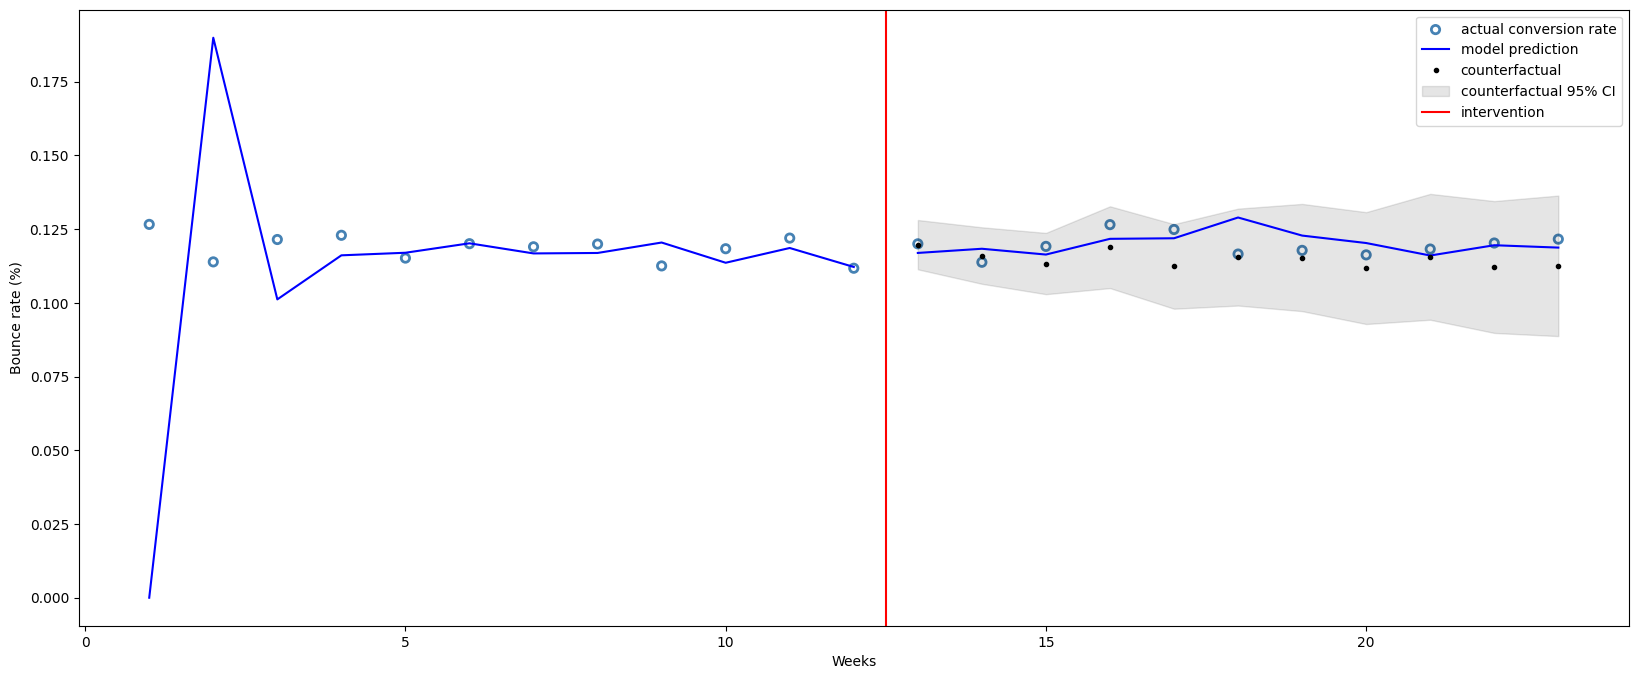

In [21]:
# begin plotting the actual data points, model prediction, and counterfactual

fig, ax = plt.subplots(figsize=(20,8))

ax.scatter(df_test['week'], df_test['converted'], facecolors='none', edgecolors='steelblue', label="actual conversion rate", linewidths=2)

# plot model mean bounce prediction
ax.plot(df_test['week'][:start], y_summary['mean'][:start], 'b-', label="model prediction")
ax.plot(df_test['week'][start:], y_summary['mean'][start:], 'b-')

# plot the counterfactual
ax.plot(df_test['week'][start:], y_cf['mean'], 'k.', label="counterfactual")
ax.fill_between(df_test['week'][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")

# plot line marking intervention moment
ax.axvline(x=12.5, color='r', label='intervention')

ax.legend(loc='best')
plt.xlabel("Weeks")
plt.ylabel("Bounce rate (%)")

plt.show()

In [35]:
# now we can wrap it into the its_stats class
# you can find it inside its_stats folder

import statsmodels.api as sm
import matplotlib.pyplot as plt


class ItsStats():

    def __init__(self, df, its_model, cf_model, t_col, y_col, start, end, constant=True):

        self.df = df
        self.its_model = its_model
        self.cf_model = cf_model
        self.t_col = t_col
        self.y_col = y_col
        self.start = start
        self.end = end
        self.constant = constant


    @staticmethod
    def summary_frame(self):

        df = self.df
        its_model = self.its_model
        cf_model = self.cf_model
        y_col = self.y_col
        start = self.start
        end = self.end
        constant = self.constant

        y_pred = its_model.get_prediction(0, end - 1)
        y_its = y_pred.summary_frame(alpha=0.05)

        if constant == True:
            exog_w_intercept_cf = sm.add_constant(df[y_col][start:])
        else:
            exog_w_intercept_cf = df[y_col][start:]

        y_cf = cf_model.get_forecast(steps=end-start, exog=exog_w_intercept_cf).summary_frame(alpha=0.05)

        return y_its, y_cf


    def plot_its(self):
        
        df = self.df
        t_col = self.t_col
        y_col = self.y_col
        start = self.start
        
        y_its, y_cf = self.summary_frame(self)

        fig, ax = plt.subplots(figsize=(20,8))

        ax.scatter(df[t_col], df[y_col], facecolors='none', edgecolors='steelblue', label="actual", linewidths=2)

        # plot model mean bounce prediction
        ax.plot(df[t_col][:start], y_its['mean'][:start], 'b-', label="model prediction")
        ax.plot(df[t_col][start:], y_its['mean'][start:], 'b-')

        # plot the counterfactual
        ax.plot(df[t_col][start:], y_cf['mean'], 'k.', label="counterfactual")
        ax.fill_between(df[t_col][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")

        # plot line marking intervention moment
        ax.axvline(x=12.5, color='r', label='intervention')

        ax.legend(loc='best')
        plt.xlabel("T")
        plt.ylabel("Y")

        plt.show()

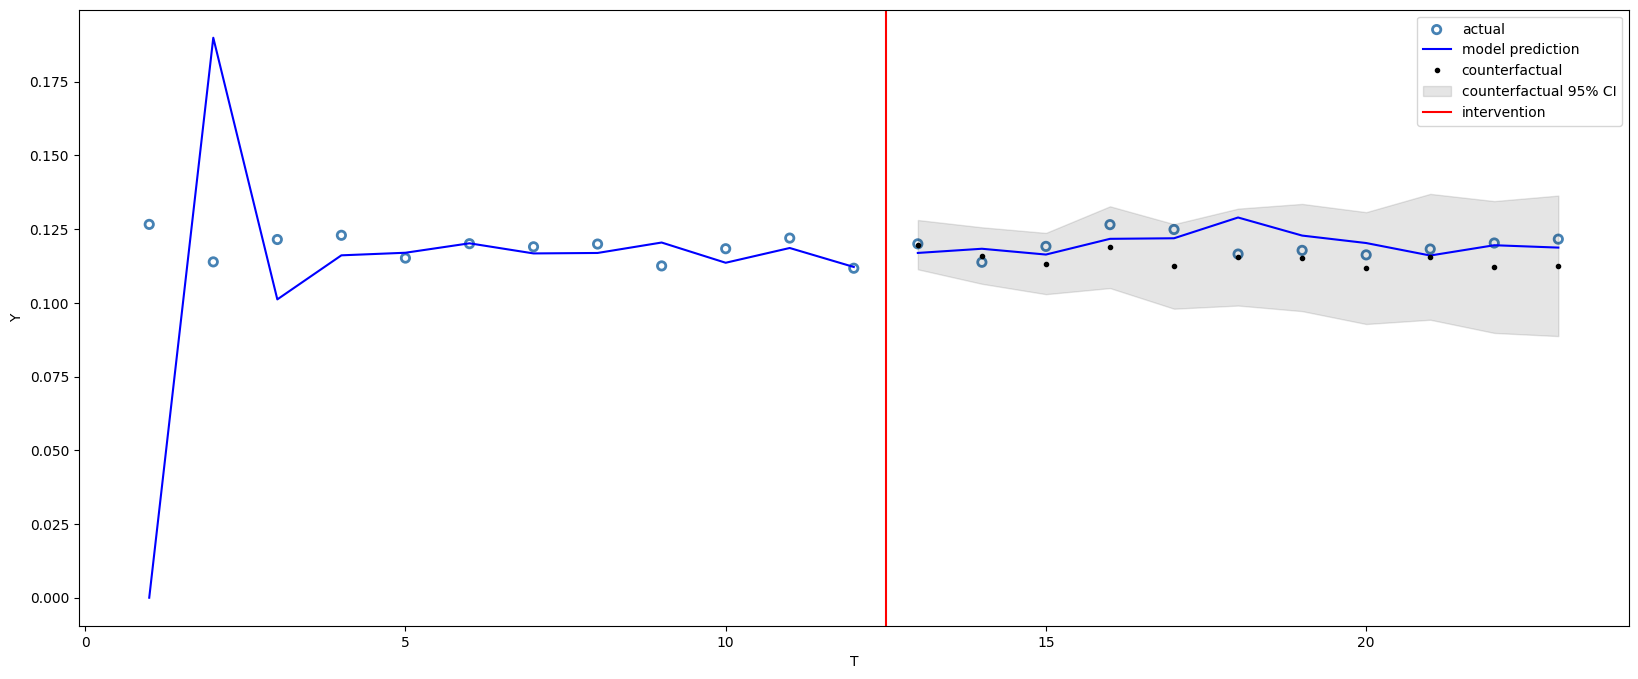

In [36]:
its_stats = ItsStats(df_test, its_model, its_cf_model, t_col='week', y_col='converted', start=12, end=23, constant=True)
its_stats.plot_its()

# 4. Bayesian ITS

When dealing with **limited resources for a full-fledged A/B testing, such as insufficient website traffic**, the standard frequentist approach may struggle to detect significant effects due to the need for a certain minimum sample size. In such cases, **Bayesian ITS offers a more flexible alternative**. Bayesian analysis can incorporate prior information, making it better suited for handling smaller sample sizes. This flexibility allows Bayesian analysis to achieve meaningful estimates and hypothesis tests even with limited data, compared to frequentist approaches which often require larger sample sizes for similar levels of precision.

In this section, we will show you the example on how to do the Bayesian ITS. 

## 4.1. Dataset

We will now explore a different dataset from <a href="https://www.xboard.dev/posts/2020_01_01_interrupted-time-series-python-part-I/index.html">xboard.dev</a>. Bob manages a popular personal finance blog and recently learned that improving his website's loading speed could reduce its bounce rate. As a result, he decided to invest in a CDN (Content Delivery Network) service. It has been 6 months since he implemented the CDN, and he is interested in determining if this investment has indeed reduced the bounce rate.

The publisher of the data itself (xboard.dev) has already conducted an ITS analysis using a frequentist approach. You can find more details on their analysis by visiting the website linked above. Now, we'll take a different approach using Bayesian ITS.

### 4.1.1. Data profile

In [434]:
df = pd.read_csv('dataset/cdn_data.csv')
df.head(5)

,bouncing rate (%),Week number
0,12.91645,1
1,13.03090,2
2,13.05717,3
3,13.16564,4
4,13.19299,5


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bouncing rate (%)  48 non-null     float64
 1   Week number        48 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 896.0 bytes


Bob has shared 48 weeks of data, with the first 24 weeks representing the period before adding the CDN (intervention), and the subsequent 24 weeks representing the period after the intervention. The data includes the bounce rate (%) and the week number for each record. It looks that the data is already clean enough. So from now on, the only thing we have to do is to make transformation into our data and make the statistical analysis.

### 4.1.2. Transformation and EDA

In [446]:
intervention_start_week = 24

df['Intervention'] = [1 if x >= intervention_start_week else 0 for x in df.index]
df['Intervention week'] = [i - intervention_start_week if i >= intervention_start_week else 0 for i in range(1, len(df) + 1)]
df.tail(5)

,bouncing rate (%),Week number,Intervention,Intervention week
43,12.23644,44,1,20
44,12.04123,45,1,21
45,12.44852,46,1,22
46,12.73959,47,1,23
47,12.56636,48,1,24


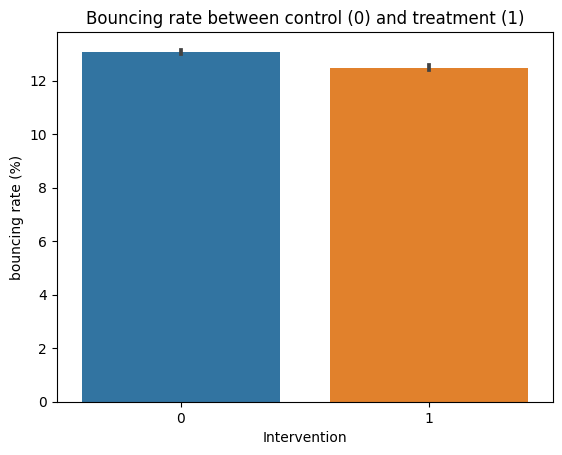

In [457]:
# barplot between control and treatment

sns.barplot(x=df['Intervention'], y=df['bouncing rate (%)'])
plt.title('Bouncing rate between control (0) and treatment (1)')
plt.show()

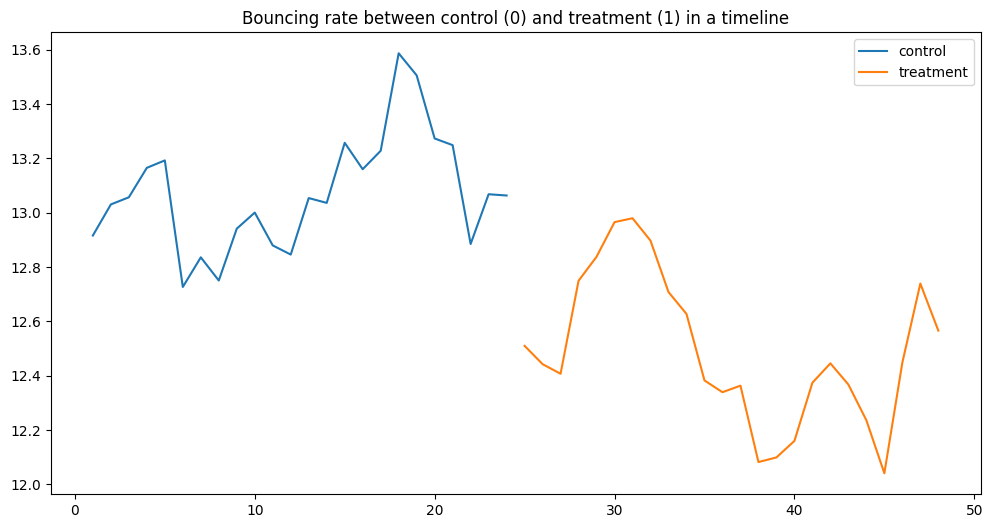

In [465]:
# timeseries between control andd treatment

plt.figure(figsize=(12,6))

plt.plot(df['Week number'][:intervention_start_week], df['bouncing rate (%)'][:intervention_start_week], label='control')
plt.plot(df['Week number'][intervention_start_week:], df['bouncing rate (%)'][intervention_start_week:], label='treatment')

plt.legend()
plt.title('Bouncing rate between control (0) and treatment (1) in a timeline')
plt.show()

In [476]:
diff_mean = df[df['Intervention'] == 1]['bouncing rate (%)'].mean() - df[df['Intervention'] == 0]['bouncing rate (%)'].mean()
print(f'with the treatment, the mean difference of bouncing rate after and before treatment is:', round(diff_mean, 3))

with the treatment, the mean difference of bouncing rate after and before treatment is: -0.581


With a simple analysis, it appears that the bounce rate has decreased after the treatment. However, to ensure the reliability of this conclusion, we will conduct a Bayesian Interrupted Time Series (ITS) analysis, which provides a more robust methodology for evaluating the impact of the intervention.

## 4.2. Statistical Analysis

In [477]:
# change the labels first to make the code prettier

df = df.rename(columns={'bouncing rate (%)': 'Y',
                        'Week number': 'T',
                        'Intervention': 'D',
                        'Intervention week': 'P'}
                        )

df.head(5)

,Y,T,D,P
0,12.91645,1,0,0
1,13.03090,2,0,0
2,13.05717,3,0,0
3,13.16564,4,0,0
4,13.19299,5,0,0


### 4.2.1. Frequentist ITS

In [505]:
import pmdarima as pm

# use the pmdarima library to look for the best parameters
# set "trace" parameter as true to be able to track how the model attempts to look for the variables

sarimax_model = pm.auto_arima(df['Y'], 
                              test='adf',
                              start_p=0,
                              d=0,
                              start_q=0,
                              seasonal=True,
                              trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.799, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16.546, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10.780, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=382.865, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-14.840, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14.876, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-13.201, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.154 seconds


In [506]:
import statsmodels.api as sm

exog_with_intercept = sm.add_constant(df[['T', 'D', 'P']])

its_model = sm.tsa.SARIMAX(endog=df['Y'],
                           exog=exog_with_intercept,
                           order=(1,0,0),
                           seasonal_order=(0,0,0,0)
                           ).fit()

its_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84237D-01    |proj g|=  2.27684D+00

At iterate    5    f= -3.86390D-01    |proj g|=  4.71425D-01

At iterate   10    f= -3.86444D-01    |proj g|=  1.57154D-01

At iterate   15    f= -3.86536D-01    |proj g|=  4.85559D-01

At iterate   20    f= -3.86906D-01    |proj g|=  1.75622D-01

At iterate   25    f= -3.86917D-01    |proj g|=  4.59514D-03

At iterate   30    f= -3.86955D-01    |proj g|=  4.72125D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/taufiqurrohman/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      Y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  18.574
Date:                Wed, 06 Mar 2024   AIC                            -25.148
Time:                        09:22:34   BIC                            -13.921
Sample:                             0   HQIC                           -20.905
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9172      0.279     46.245      0.000      12.370      13.465
T              0.0121      0.016      0.767      0.443      -0.019       0.043
D             -0.5510      0.273     -2.018      0.044      -1.086      -0.016
P             -0.0238      0.021     -1.155      0.248      -0.064       0.017
ar.L1          0.6635      0.138      4.803      0.000       0.393       0.934
sigma2         0.0267      0.006      4.771      0.000       0.016       0.038
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.32   Prob(JB):                         0.93
Heteroskedasticity (H):               1.44   Skew:                            -0.05
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using frequentist ITS methods, we determined that the treatment's p-value (variable D) is < 0.05, indicating **statistical significance in explaining the conversion rate.** Moreover, based on the regression coefficient, this model indicates that, on average, **the new CDN has reduced the website's bounce rate by 0.55%.**

Now, let's move on and compare the result with the Bayesian ITS.

### 4.2.2. Bayesian ITS

As you may recall from the model, the Interrupted Time Series (ITS) methodology consists of two main components: 1) the treatment effect, and 2) **SARIMAX variables.** The same principle applies to Bayesian ITS; however, in Bayesian ITS, it is more commonly referred to as the **Bayesian Structural Time Series (BSTS) model.** Some also call this as Unobservable Components (UC). BSTS is a Bayesian approach to time series modeling that can fit models similar to ARIMA models while incorporating Bayesian priors and uncertainties.

BSTS offers flexibility in modeling time series data and can accommodate various components such as trend, seasonality, and autoregressive components. It employs Bayesian inference to estimate model parameters and provides posterior distributions for these parameters, enabling probabilistic forecasts and quantification of uncertainty. A key advantage of BSTS over SARIMAX is its ability to account for harmonics within seasonality. For instance, BSTS can capture weekly seasonality within monthly patterns, offering a more comprehensive modeling approach.

#### 4.2.2.1. Bayesian ITS is not straightforward

Implementing Bayesian Interrupted Time Series (ITS) analysis poses greater challenges compared to using a frequentist approach. A key difficulty lies in reconfiguring the SARIMA components and harmonics within a Bayesian framework. Currently, there is no single library that offers a straightforward solution for this task. The PyMC library has made some progress by integrating the autoregressive component into their model construction using `pymc.model.AR`. However, an individual has successfully tackled this challenge by combining `statsmodels.UnobservedComponents` with `PyMC`. For more information, you can visit this <a href='https://juanitorduz.github.io/uc_pymc/'>link</a>. 

Another option is to leverage Facebook's Prophet library, particularly when dealing with time series exhibiting strong, multiple seasonalities. It's important to note that Prophet does not support the inclusion of ARIMA components in the model.

Fortunately, in our dataset, we **only need to consider the AR(1) component** in the time series. Therefore, we can utilize the standard PyMC library, which provides support for estimating autoregressive components, to handle this aspect of the analysis.

#### 4.2.2.2. Bayesian Regression

Before we do the example, it's the best to understand in a higher level on how to do a Bayesian Regression. As you notice, the previous ITS model we built is basically a multiple linear regression. In frequentist approach, looking for each beta coefficients are much simpler rather than Bayesian. In Bayesian, the high level process looks like this:

1. **Likelihood**: Start with a likelihood function that describes the relationship between the predictors and the outcome variable. For example, in linear regression, the likelihood might be normally distributed.

2. **Priors**: Assign prior distributions to each coefficient in the model. For numerical variables, you might use a normal or a more informative distribution if you have prior knowledge. For categorical variables, you might use a categorical or multinomial distribution.

3. **Prior Combination**: Multiply all the prior distributions together to get the joint prior distribution. This is based on the assumption of independence between the coefficients, which may not always hold but is often a simplifying assumption.

4. **Posterior Calculation**: Multiply the likelihood by the joint prior to get the joint posterior distribution. This distribution represents our updated beliefs about the coefficients after observing the data.

5. **Posterior Inference**: Use the posterior distribution to make inferences about the coefficients. This can involve calculating credible intervals, posterior means, or other summaries of the posterior distribution.

6. **Model Comparison**: Bayesian regression also allows for model comparison using methods like Bayesian Information Criterion (BIC) or posterior predictive checks to assess the fit and complexity of the model.

The choice of prior distributions can greatly influence the results of Bayesian regression. It's important to carefully consider the choice of priors based on prior knowledge, the scale of the data, and the desired properties of the posterior distribution. 

Alright, for Bayesian regression, we have two options: PyMC or a library called `Bambi (BAyesian Model-Building Interface in Python)`. While building a Bayesian regression model with PyMC requires a deeper understanding, Bambi simplifies the process by allowing users to construct models using a formula syntax similar to statsmodels.formula.api. You can take a look at Bambi's documentation <a href="https://bambinos.github.io/bambi/">here.</a>

Now, let's do this.

#### 4.2.2.3. Example Using Bambi + PyMC + Arviz

In [536]:
# make some transformation into the data to generate ar-1
# the specification of the time series is ARIMA(1,0,0)

df_bayes = df.copy(deep=True)
df_bayes['ar1'] = df_bayes['Y'].shift(1)
df_bayes.head(5)

,Y,T,D,P,ar1
0,12.91645,1,0,0,NaN
1,13.03090,2,0,0,12.91645
2,13.05717,3,0,0,13.03090
3,13.16564,4,0,0,13.05717
4,13.19299,5,0,0,13.16564


In [539]:
import arviz as az
import bambi as bmb

# build and fit the model using formula
# bambi is basically built on pymc, so it will be estimated using MCMC

model = bmb.Model(formula='Y ~ T + D + P + ar1', 
                  data=df_bayes,
                  dropna=True)

results = model.fit(draws=1000, chains=4)

Automatically removing 1/48 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Y_sigma, Intercept, T, D, P, ar1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [541]:
# now, let's take a look at the prior that was set up by bambi
# in bambi, if we don't set the prior in advance, it will set a weak-informative prior to give some flexibility

model.plot_priors

<bound method Model.plot_priors of        Formula: Y ~ T + D + P + ar1
        Family: gaussian
          Link: mu = identity
  Observations: 47
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 12.7783, sigma: 32.1171)
            T ~ Normal(mu: 0.0, sigma: 0.0703)
            D ~ Normal(mu: 0.0, sigma: 1.9073)
            P ~ Normal(mu: 0.0, sigma: 0.1196)
            ar1 ~ Normal(mu: 0.0, sigma: 2.5052)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.3814)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()>

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.969,1.640,1.957,8.057,0.030,0.021,3049.0,2943.0,1.0
T,0.004,0.006,-0.007,0.016,0.000,0.000,2314.0,2435.0,1.0
D,-0.252,0.122,-0.471,-0.023,0.002,0.002,2674.0,2757.0,1.0
P,-0.006,0.010,-0.024,0.012,0.000,0.000,2557.0,2583.0,1.0
ar1,0.617,0.127,0.370,0.846,0.002,0.002,2966.0,2857.0,1.0
Y_sigma,0.189,0.021,0.152,0.228,0.000,0.000,3603.0,2743.0,1.0


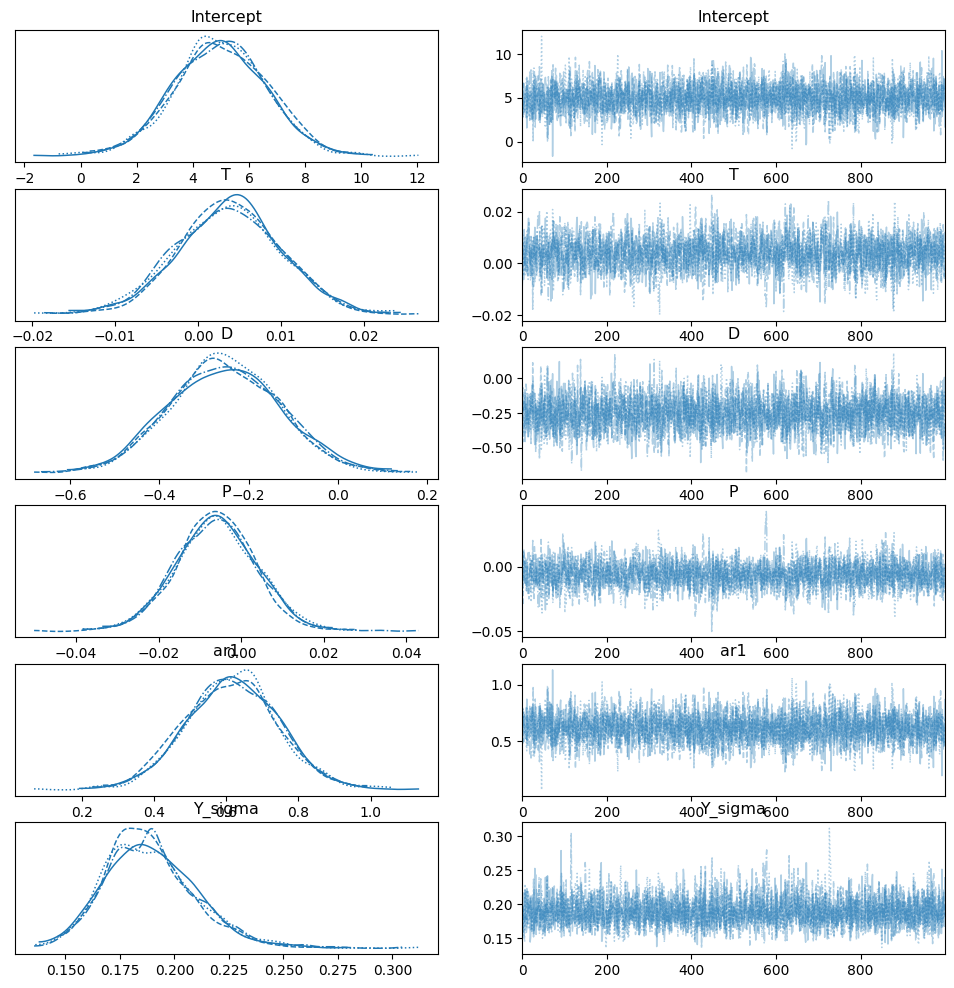

In [542]:
# now, let's take a look at the results

az.plot_trace(results)
az.summary(results)

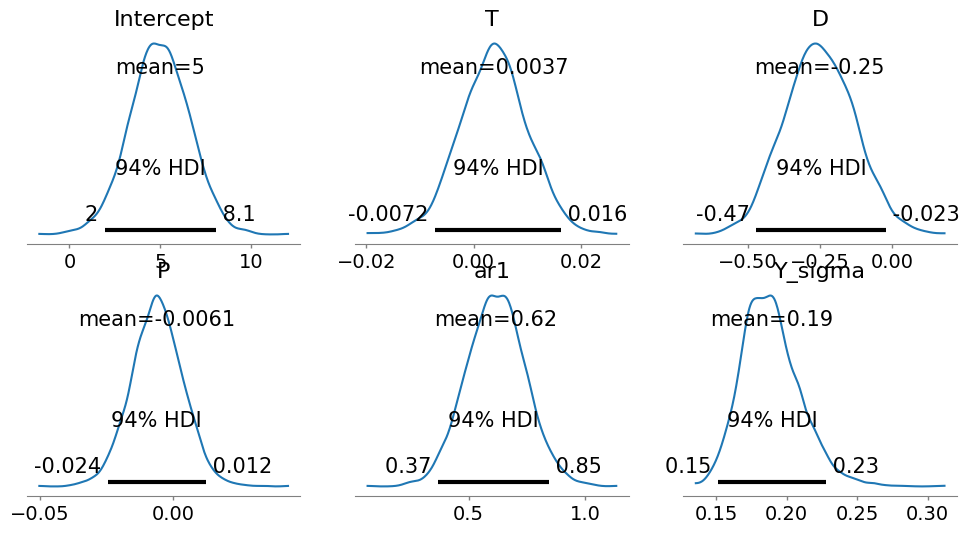

In [554]:
pm.plot_posterior(results, figsize=(12,6))
plt.show()

#### 4.2.2.4. Example Using Bambi + PyMC + Arviz with Defining the Prior

In [564]:
import arviz as az
import bambi as bmb
import pymc as pm

# now, let's try to set the prior for D variable
# assumption with weakly informative, a standard normal distribution

priors = {
    'D': bmb.Prior('Normal', mu=0, sigma=1)
}

model = bmb.Model(formula='Y ~ T + D + P + ar1', 
                  data=df_bayes,
                  priors=priors,
                  dropna=True)

results = model.fit(draws=1000, chains=4)

Automatically removing 1/48 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Y_sigma, Intercept, T, D, P, ar1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.981,1.645,1.839,8.063,0.029,0.021,3136.0,2854.0,1.0
T,0.004,0.006,-0.009,0.015,0.000,0.000,2751.0,2492.0,1.0
D,-0.248,0.121,-0.477,-0.025,0.002,0.002,3018.0,2718.0,1.0
P,-0.006,0.009,-0.025,0.010,0.000,0.000,2764.0,2441.0,1.0
ar1,0.616,0.127,0.371,0.853,0.002,0.002,3041.0,2744.0,1.0
Y_sigma,0.190,0.021,0.155,0.233,0.000,0.000,2672.0,2633.0,1.0


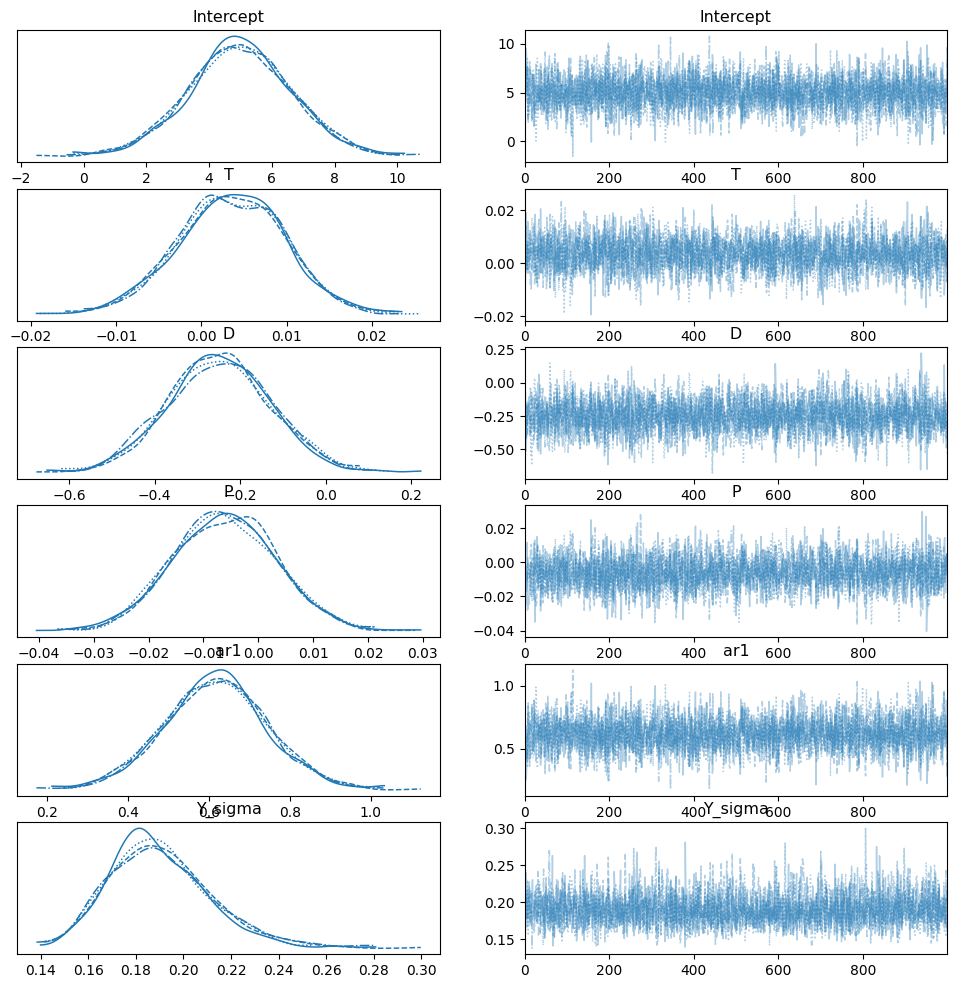

In [565]:
az.plot_trace(results)
az.summary(results)

#### 4.2.2.5. Making an Inference

As we're only interested in whether the intervention makes any differences, we will only interpret the parameter D here. The mean estimate for the parameter D is -0.252, with a standard deviation of 0.122. The 95% credible interval for D is [-0.471, -0.023]. This suggests that **D has a negative effect, and we are 95% confident that the true value of D falls within this interval [-0.471, -0.023].**

While our primary focus is on the parameter D, there is also valuable information to be gleaned from T and P. The average estimate for T is 0.004, with a standard deviation of 0.006, and its 95% credible interval spans from -0.007 to 0.016. On the other hand, the mean estimate for P is -0.006, with a standard deviation of 0.010, and its 95% credible interval ranges from -0.024 to 0.012. It indicates that **T and P have a small positive effect, but the estimate is uncertain, as the credible interval includes zero.**


# Reading Material

- Interrupted Time Series: https://www.xboard.dev/posts/2020_01_01_interrupted-time-series-python-part-I/index.html
- Combining statsmodels + pymc to create a BSTS: https://juanitorduz.github.io/uc_pymc/
- Documentation on bambi library: https://bambinos.github.io/bambi/